<div><img style="float: right; width: 120px; vertical-align:middle" src="https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/EU_Informatica/ETSI%20SIST_INFORM_COLOR.png" alt="ETSISI logo" />


# Práctica 1: Autoencoders y VAEs

<i><small>Authors: Félix  Fuentes Hurtado<br>Last update: 2023-10-11</small></i></div>

***

En esta práctica vais a poner en juego los conocimientos adquiridos sobre Autoencoders y Autoencoders Variacionales. Para ello, llevaréis a cabo las siguientes tareas:

- Construir y entrenar un VAE **convolucional**.
- Re-implementar el VAE convolucional empleando el GradientTape de TensorFlow y un *training loop* personalizado

## Parte 1: Implementación de un VAE convolucional

Antes de nada, obtendremos y prepararemos los datos:

In [ ]:
import numpy as np
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


Ahora definiremos el encoder y el decoder, así como la función que permitirá entrenar al VAE haciendo uso del "reparameterization trick".

Primero crearemos una capa personalizada para realizar el ["truco de reparametrización"](https://www.baeldung.com/cs/vae-reparameterization).

**Pregunta**: Lee el enlace anterior y explica brevemente en qué consiste el "truco de reparametrización".


**Respuesta**: El truco de reparametrización consiste en introducir un vector de ruido que se combina con la media y la varianza de la distribución para generar una muestra. Esto mejora la eficiencia y la estabilidad en la optimización de un VAE al separar la aleatoriedad del proceso de entrenamiento.

In [ ]:
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras import backend as K

input_dim = (28, 28, 1)
latent_dim = 2

# encoder

inputs = layers.Input(shape=input_dim)

x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
x = layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name='z_mean')(x)
z_log_sigma = layers.Dense(latent_dim, name='z_log_sigma')(x)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=1.0)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

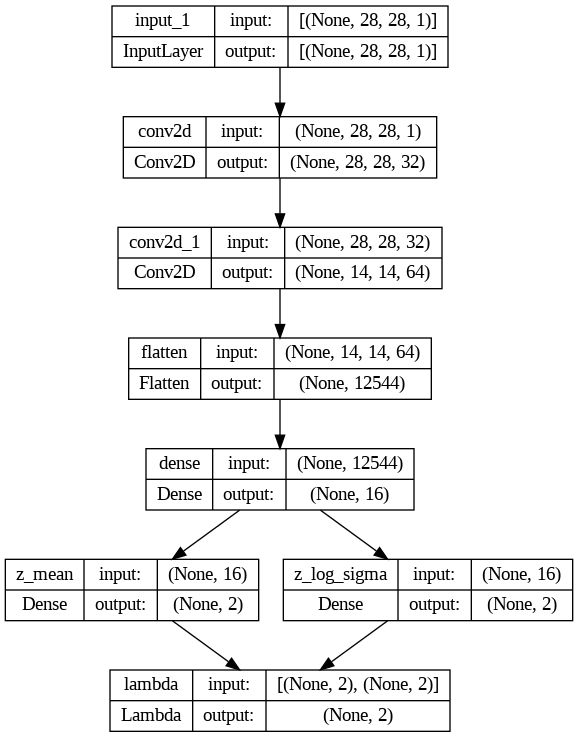

In [ ]:
from keras.utils import plot_model
plot_model(encoder, show_shapes=True)

In [ ]:
# Create decoder

latent_inputs = layers.Input(shape=latent_dim)

x = layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
outputs = layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)

decoder = keras.Model(latent_inputs, outputs, name='decoder')

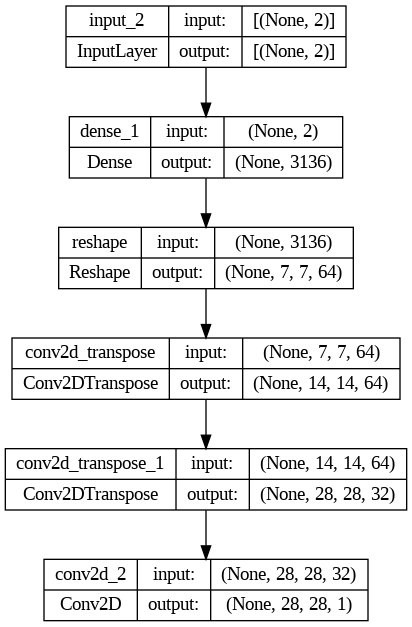

In [ ]:
from keras.utils import plot_model
plot_model(decoder, show_shapes=True)

In [ ]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_cnn')

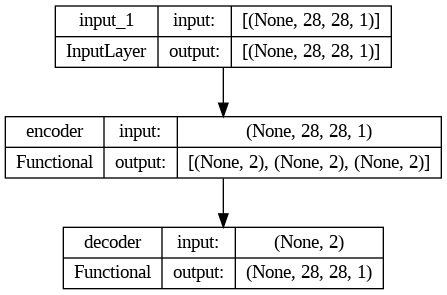

In [ ]:
from keras.utils import plot_model
plot_model(vae, show_shapes=True)

In [ ]:
# loss function
reconstruction_loss = keras.losses.binary_crossentropy(K.flatten(inputs), K.flatten(outputs))
reconstruction_loss *= 28 * 28

kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
vae.fit(x_train, x_train,
        epochs=30,
        batch_size=128,
        validation_data=(x_test, x_test))

Epoch 1/30
469/469 [==============================] - 19s 15ms/step - loss: 219.0251 - val_loss: 188.3407
Epoch 2/30
469/469 [==============================] - 6s 13ms/step - loss: 185.4204 - val_loss: 182.7258
Epoch 3/30
469/469 [==============================] - 6s 14ms/step - loss: 181.9165 - val_loss: 179.5625
Epoch 4/30
469/469 [==============================] - 7s 14ms/step - loss: 180.0579 - val_loss: 177.9496
Epoch 5/30
469/469 [==============================] - 7s 14ms/step - loss: 178.7107 - val_loss: 176.8509
Epoch 6/30
469/469 [==============================] - 7s 14ms/step - loss: 177.6492 - val_loss: 175.9099
Epoch 7/30
469/469 [==============================] - 6s 14ms/step - loss: 176.8438 - val_loss: 175.5330
Epoch 8/30
469/469 [==============================] - 7s 14ms/step - loss: 176.3289 - val_loss: 175.1488
Epoch 9/30
469/469 [==============================] - 6s 14ms/step - loss: 175.8393 - val_loss: 174.7911
Epoch 10/30
469/469 [==============================] -

Y con esto, tenemos nuestro primer VAE Convolucional implementado.

Veamos las muestras que podemos generar:

1/1 [==============================] - 0s 18ms/step


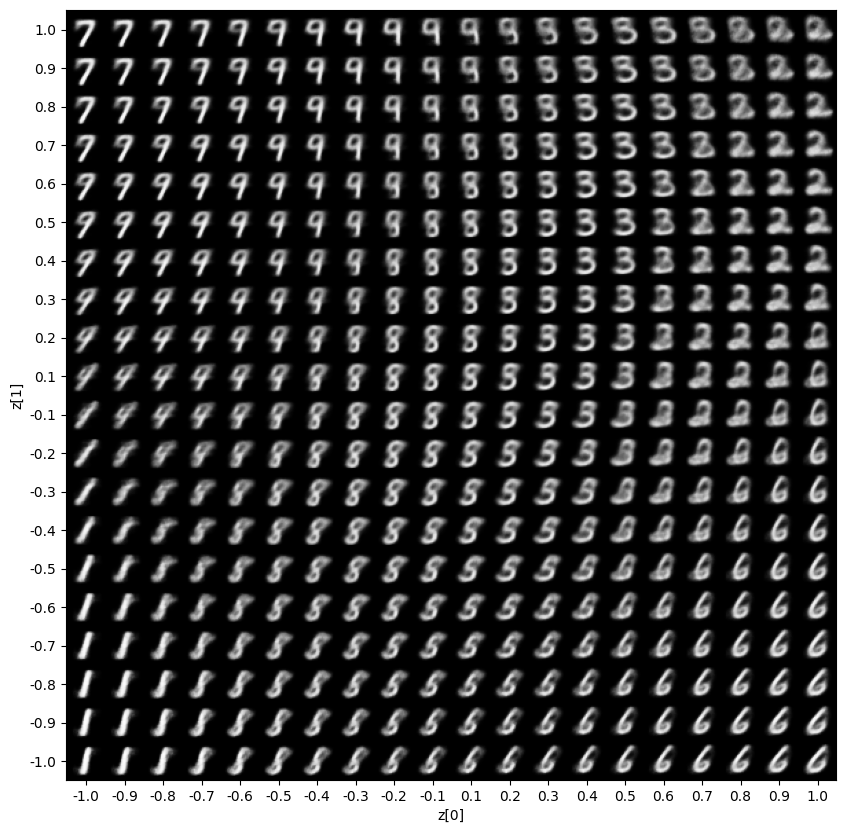

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(decoder, n=15, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(decoder, n=20, figsize=10)

Y el espacio latente, tanto del conjunto de entrenamiento como del de test.

1875/1875 [==============================] - 4s 2ms/step


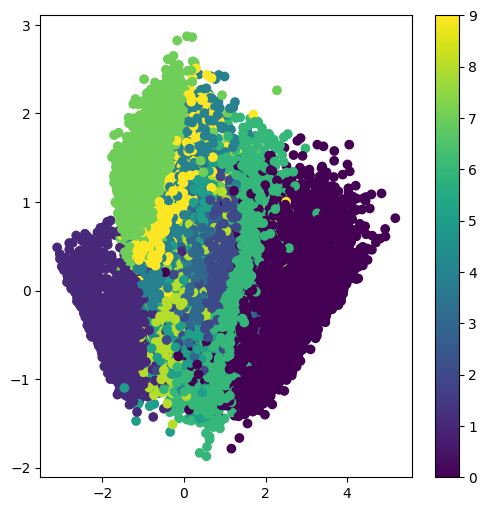

In [ ]:
import matplotlib.pyplot as plt

x_train_encoded = encoder.predict(x_train, batch_size=32)
x_train_encoded = np.asarray(x_train_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[2, :, 0], x_train_encoded[2, :, 1], c=y_train)
plt.colorbar()
plt.show()

313/313 [==============================] - 1s 2ms/step


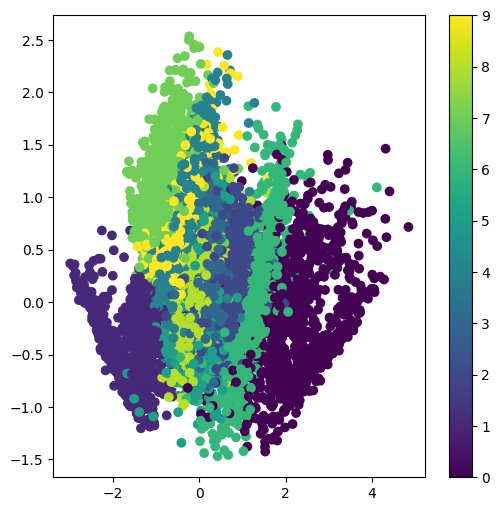

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

**Pregunta**: ¿Qué diferencias observas?

**Respuesta**: El espacio latente del conjunto de test tiene menos volumen todas las clases en general, ya que el conjunto de datos es menor que el conjunto de entrenamiento. El espacio que ocupan es relativamente el mismo, pero al estar menos poblado en el conjunto de test, se pueden observar varios puntos "sueltos".

## Parte 2: Re-implementar el VAE convolucional empleando el GradientTape de TensorFlow y un *training loop* personalizado

La forma de programar con `GradientTape` y la creación de un bucle de entrenamiento personalizado en Keras ofrece ventajas significativas en comparación con la API secuencial y funcional de Keras en situaciones específicas. Algunas de estas ventajas son:

1. **Flexibilidad completa**: Con un bucle de entrenamiento personalizado tenéis un control total sobre cada paso del proceso de entrenamiento. Podéis implementar algoritmos de entrenamiento altamente personalizados y manejar situaciones que no son fáciles de abordar con modelos secuenciales o funcionales predefinidos, como por ejemplo, estructuras complejas.

2. **Investigación y experimentación**: Para investigadores y científicos que necesitan probar hipótesis, realizar experimentos y explorar nuevas arquitecturas de modelos, la programación personalizada con `GradientTape` brinda la flexibilidad necesaria. Podéis modificar el comportamiento del modelo y el proceso de entrenamiento en cada iteración.

3. **Regulación y pérdidas personalizadas**: Algunas aplicaciones requieren funciones de pérdida personalizadas o métodos de regularización no disponibles en la API secuencial o funcional. Con un bucle de entrenamiento personalizado, podéis implementar y ajustar estas funciones según sea necesario.

4. **Control absoluto de los gradientes**: `GradientTape` os permite acceder y modificar los gradientes en cada paso del entrenamiento, lo que puede ser esencial para aplicar técnicas de optimización avanzadas, como gradientes acoplados, cálculo de gradientes en funciones no diferenciables o personalización de reglas de actualización de pesos, por ejemplo.

5. **Análisis e inspección detallada**: Al escribir un bucle de entrenamiento personalizado, podéis realizar un seguimiento y análisis detallado de métricas e información en cada paso del entrenamiento, lo que es útil para el depuración, la monitorización y la recopilación de datos para la investigación.

Sin embargo, es importante destacar que las API secuenciales y funcionales de Keras son ideales para tareas comunes y suelen ser más fáciles de usar y más eficientes en términos de código.

La programación personalizada es más adecuada cuando se requiere un mayor control y adaptabilidad.

Para llevar a cabo esta implementación, deberéis completar los siguientes pasos:

- Definición de la arquitectura propia haciendo uso de `tf.keras.Model`
- Definición de la función de pérdidas
- Definición del comportamiento del modelo durante el *forward pass* (método `train_step` de la clase)
- Compilar `model.compile(...)` y entrenar `model.fit(...)` el modelo.

Estos son los pasos básicos.

Sin embargo, veremos que de esta forma todavía es `Keras` quien se encarga de "alimentar" el modelo. Esto es un paso intermedio entre la máxima personalización y las APIs funcionales y secuenciales que ofrece Keras. Todavía es posible personalizar más el proceso de entrenamiento, pero eso ya se lo dejo a quien le interese :)

Podéis leer sobre ello aquí: https://keras.io/guides/writing_a_training_loop_from_scratch/

### Definición de la arquitectura

In [1]:
import tensorflow as tf

Primero crearemos una capa personalizada implementando el ["truco de reparametrización"](https://www.baeldung.com/cs/vae-reparameterization):

In [2]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


Ahora la arquitectura en sí: el encoder, el decoder y sus comportamientos:

In [3]:
import numpy as np
import tensorflow as tf

class ConvolutionalVAE(tf.keras.Model):

    def __init__(self, input_shape, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = self.get_encoder(input_shape)
        self.decoder = self.get_decoder(latent_dim)

        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    # mediante esta porción de código definimos las métricas que queremos
    # vigilar durante el entrenamiento
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    # define the encoder
    def get_encoder(self, input_shape=(28, 28, 1), latent_dim=2):

        # encoder
        encoder_inputs = tf.keras.Input(shape=input_shape)

        x = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(encoder_inputs)
        x = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(16, activation='relu')(x)

        z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
        z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)

        z = Sampling()([z_mean, z_log_var])

        encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

        return encoder

    # define the decoder
    def get_decoder(self, latent_dim):

        latent_inputs = tf.keras.layers.Input(shape=(latent_dim,), name='z_sampling')

        x = tf.keras.layers.Dense(7 * 7 * 64, activation='relu')(latent_inputs)
        x = tf.keras.layers.Reshape((7, 7, 64))(x)
        x = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
        x = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
        decoder_outputs = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

        decoder = tf.keras.Model(latent_inputs, decoder_outputs, name='decoder')

        return decoder

    # aquí podemos definir lo que queremos que ocurra en cada iteración del
    # bucle de entrenamiento
    def train_step(self, data):

        # el GradientTape es el objeto que llevará un control de los gradientes
        # y el que permitirá que se actualicen los pesos
        with tf.GradientTape() as tape:

            # codificamos los datos de entrada
            z_mean, z_log_var, z = self.encoder(data)

            # reconstruimos los datos de entrada
            reconstruction = self.decoder(z)

            # calculamos las pérdidas de reconstrucción
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )

            # calculamos las pérdidas KL
            kl_loss = -0.5 * tf.reduce_mean(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))

            total_loss = reconstruction_loss + kl_loss

        # obtenemos los gradientes de los parámetros (pesos y bias) a ajustar (entrenar)
        grads = tape.gradient(total_loss, self.trainable_weights)

        # optimizamos los pesos (los ajustamos, aquí es donde realmente se entrena la red)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # actualizamos las métricas
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


Ya tenemos la arquitectura definida, junto con las pérdidas y el `train_step`.

Ya solo nos queda alimentar el modelo y entrenarlo, y comprobar los resultados.

Vamos a preparar los datos del MNIST.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255.
x_test = np.expand_dims(x_test, -1).astype("float32") / 255.

11490434/11490434 [==============================] - 2s 0us/step


Ahora instanciamos el modelo:

In [5]:
input_shape = (28, 28, 1)
latent_dims = 2
vae = ConvolutionalVAE(input_shape, latent_dims)

Lo compilamos y por último, lo entrenamos.

Fijaos en que en esta ocasión, como tenemos control sobre el *training loop*, le introducimos solo los datos `x_train`, ya que en el `train_step` solo usaremos esos datos (como ambas entradas a la función de pérdidas de reconstrucción).

In [6]:
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(x_train, epochs=30, batch_size=128)

Epoch 1/30
469/469 [==============================] - 22s 9ms/step - loss: 266.6740 - reconstruction_loss: 213.8109 - kl_loss: 2.1017
Epoch 2/30
469/469 [==============================] - 4s 8ms/step - loss: 183.2503 - reconstruction_loss: 172.7072 - kl_loss: 2.8210
Epoch 3/30
469/469 [==============================] - 4s 9ms/step - loss: 163.5182 - reconstruction_loss: 159.1945 - kl_loss: 3.0147
Epoch 4/30
469/469 [==============================] - 4s 8ms/step - loss: 159.1955 - reconstruction_loss: 155.2353 - kl_loss: 3.1230
Epoch 5/30
469/469 [==============================] - 4s 8ms/step - loss: 156.7055 - reconstruction_loss: 152.9863 - kl_loss: 3.2020
Epoch 6/30
469/469 [==============================] - 4s 9ms/step - loss: 155.2995 - reconstruction_loss: 151.5692 - kl_loss: 3.2566
Epoch 7/30
469/469 [==============================] - 4s 8ms/step - loss: 154.5470 - reconstruction_loss: 150.5190 - kl_loss: 3.2916
Epoch 8/30
469/469 [==============================] - 4s 8ms/step - 

Vamos a visualizar un grid de imágenes generadas con nuestro VAE para ver qué tal funciona:

1/1 [==============================] - 0s 18ms/step


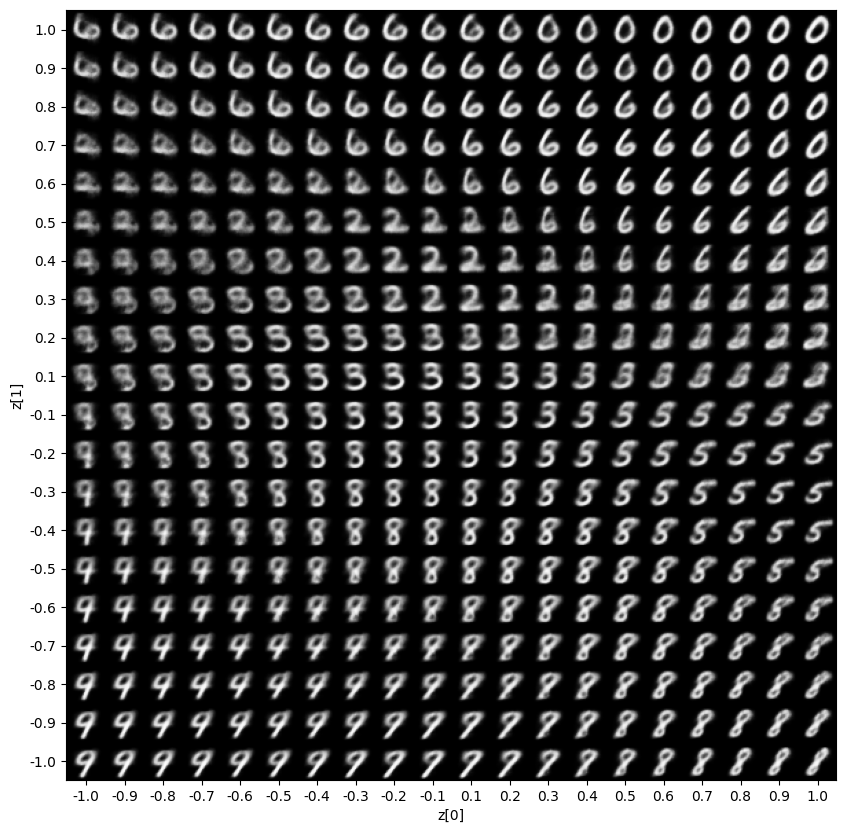

In [7]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=15, figsize=15):
    # display an n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae, n=20, figsize=10)

Y ahora lo mismo pero con los códigos latentes, tanto de train como de test.

1875/1875 [==============================] - 4s 2ms/step


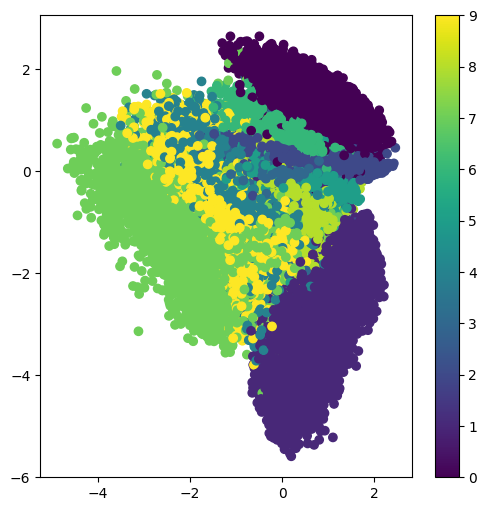

In [8]:
import matplotlib.pyplot as plt

x_train_encoded = vae.encoder.predict(x_train, batch_size=32)
x_train_encoded = np.asarray(x_train_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[0, :, 0], x_train_encoded[0, :, 1], c=y_train)
plt.colorbar()
plt.show()

313/313 [==============================] - 1s 2ms/step


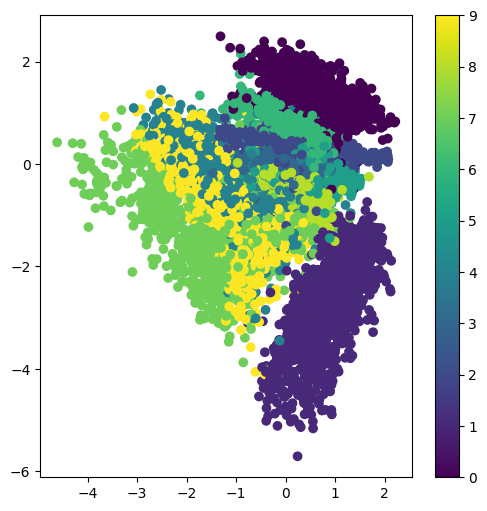

In [9]:
import matplotlib.pyplot as plt

x_test_encoded = vae.encoder.predict(x_test, batch_size=32)
x_test_encoded = np.asarray(x_test_encoded)

plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0, :, 0], x_test_encoded[0, :, 1], c=y_test)
plt.colorbar()
plt.show()